In [3]:
# This notebook will contain only some NLP methods such as n-grams because the full notebook was getting too cumbersum

In [175]:
# imports
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt

In [14]:
df_lab = pd.read_csv('Lab-Data.csv', index_col=0) # index_col stopy index being read as column
df_turk = pd.read_csv('Turk-Data.csv', index_col=0)


In [126]:
df_lab

,button,event_type,target,time,x,y,step,turkId,file
0,1,mousedown,"[id=""alloc-slider-return-4""]>svg>g>circle",0.000000,397.0,647.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
1,1,mouseup,"[id=""alloc-slider-return-4""]>svg>g>circle",0.547000,423.0,642.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
2,1,click,"[id=""alloc-slider-return-4""]>svg>g>circle",0.547000,423.0,642.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
3,1,mousedown,"[id=""alloc-slider-return-4""]>svg>g>circle",1.176995,426.0,642.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
4,1,mousedirchange,"[id=""alloc-slider-return-4""]>svg>g>circle",1.790000,440.0,640.0,1,ID1,global_sa_sl_both_2017-02-08 12_48_51.json
...,...,...,...,...,...,...,...,...,...
58280,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,1,ID18,study_results.all.json
58281,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,2,ID18,study_results.all.json
58282,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,3,ID18,study_results.all.json
58283,1,click,"[id=""portfolio-selection""]>div:nth-child(3)>di...",275.048950,942.0,1248.0,4,ID18,study_results.all.json


In [150]:
# RENAME LABS

df_lab.loc[df_lab['target'].str.contains('slider-return-0'), 'target'] = 'slider-return-0'
df_lab.loc[df_lab['target'].str.contains('slider-return-1'), 'target'] = 'slider-return-1'
df_lab.loc[df_lab['target'].str.contains('slider-return-2'), 'target'] = 'slider-return-2'
df_lab.loc[df_lab['target'].str.contains('slider-return-3'), 'target'] = 'slider-return-3'
df_lab.loc[df_lab['target'].str.contains('slider-return-4'), 'target'] = 'slider-return-4'
df_lab.loc[df_lab['target'].str.contains('slider-return-5'), 'target'] = 'slider-return-5'

# risk sliders
df_lab.loc[df_lab['target'].str.contains('slider-risk-0'), 'target'] = 'slider-risk-0'
df_lab.loc[df_lab['target'].str.contains('slider-risk-1'), 'target'] = 'slider-risk-1'
df_lab.loc[df_lab['target'].str.contains('slider-risk-2'), 'target'] = 'slider-risk-2'
df_lab.loc[df_lab['target'].str.contains('slider-risk-3'), 'target'] = 'slider-risk-3'
df_lab.loc[df_lab['target'].str.contains('slider-risk-4'), 'target'] = 'slider-risk-4'
df_lab.loc[df_lab['target'].str.contains('slider-risk-5'), 'target'] = 'slider-risk-5'

#buttons


# interesting to note that a typical Lab target may be [id="alloc-slider-risk-4"]>svg
# Where as a Turk might be html > body > main > div#content > form#portfolio-selection
# > div.investment-test > div.portfolio-interface.row > div.stock-selection.large-7.columns 
# > div.stock-allocator.row.valign-middle > div.large-4.columns > div#alloc-slider-return-0.sparkline.narrow.return 
# > svg.chart.control > g > circle.handle
# We can use the same method to rename them even though the naming scheme is different

In [19]:
# RENAME TURKS

# return sliders
df_turk.loc[df_turk['target'].str.contains('slider-return-0'), 'target'] = 'slider-return-0'
df_turk.loc[df_turk['target'].str.contains('slider-return-1'), 'target'] = 'slider-return-1'
df_turk.loc[df_turk['target'].str.contains('slider-return-2'), 'target'] = 'slider-return-2'
df_turk.loc[df_turk['target'].str.contains('slider-return-3'), 'target'] = 'slider-return-3'
df_turk.loc[df_turk['target'].str.contains('slider-return-4'), 'target'] = 'slider-return-4'
df_turk.loc[df_turk['target'].str.contains('slider-return-5'), 'target'] = 'slider-return-5'

# risk sliders
df_turk.loc[df_turk['target'].str.contains('slider-risk-0'), 'target'] = 'slider-risk-0'
df_turk.loc[df_turk['target'].str.contains('slider-risk-1'), 'target'] = 'slider-risk-1'
df_turk.loc[df_turk['target'].str.contains('slider-risk-2'), 'target'] = 'slider-risk-2'
df_turk.loc[df_turk['target'].str.contains('slider-risk-3'), 'target'] = 'slider-risk-3'
df_turk.loc[df_turk['target'].str.contains('slider-risk-4'), 'target'] = 'slider-risk-4'
df_turk.loc[df_turk['target'].str.contains('slider-risk-5'), 'target'] = 'slider-risk-5'

#buttons
df_turk.loc[df_turk['target'].str.contains('buy-button'), 'target'] = 'buy-button'
df_turk.loc[df_turk['target'].str.contains('button.save-portfolio'), 'target'] = 'save-portfolio-button'

# Idea: maybe only use mouseevents of click/mousedown to reduce the number of events?

df_turk.to_csv('Turk-Data-renamed.csv')

df_turk

,Unnamed: 0,button,event_type,target,time,x,y,step,turkId
0,0,1,mousedown,alloc-slider-1,0.000,477.0,405.0,1,A35YFAFWP33C70
1,1,1,mouseup,alloc-slider-1,0.111,478.0,405.0,1,A35YFAFWP33C70
2,2,1,click,alloc-slider-1,0.111,478.0,405.0,1,A35YFAFWP33C70
3,3,1,mousedown,alloc-slider-1,1.516,479.0,405.0,1,A35YFAFWP33C70
4,4,1,mousedirchange,alloc-slider-1,2.395,543.0,403.0,1,A35YFAFWP33C70
...,...,...,...,...,...,...,...,...,...
1293068,1293068,1,click,buy-button,258.656,500.0,2198.0,1,A15781PHGW377Y
1293069,1293069,1,click,buy-button,258.656,500.0,2198.0,2,A15781PHGW377Y
1293070,1293070,1,click,buy-button,258.656,500.0,2198.0,3,A15781PHGW377Y
1293071,1293071,1,click,buy-button,258.656,500.0,2198.0,4,A15781PHGW377Y


In [218]:



def calculate_ngrams(dataframe, n):
    # TODO docstring
    # will return a dataframe of ngrams and frequency given n
    # Can take a while to compute
    
    IDs = dataframe['turkId'].unique()
    all_ngrams = []

    for ID in IDs:
        # Get targets of each user
        targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

        ngrams_generator = nltk.ngrams(targets, 1)               # creates ngram generator, can be used to find ngrams
        ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency
        common_ngrams = ngrams_distribution.most_common()       # converts to list

        # append this useres ngrams to all ngrams
        # extend rather than append to iterate over list and not add a list of items as a single item.
        all_ngrams.extend(common_ngrams)

    # Convert list to dataframe
    df_ngrams = pd.DataFrame(all_ngrams, columns =['n-grams', 'Frequency'])
    df_ngrams = df_ngrams.astype(dtype= {"n-grams":"object", "Frequency":"int64"})

    # Change n-grams series from list of tuples to list of strings  # https://stackoverflow.com/questions/59993097/how-can-i-join-tuples-to-strings-in-a-pandas-dataframe
    df_ngrams['n-grams'] = df_ngrams['n-grams'].agg(''.join)

    # Sum the frequencies of similar ngrams.
    df_ngrams = df_ngrams.groupby(['n-grams']).sum().reset_index().sort_values(by='Frequency', ascending=False)

    # 'Normalise' the frequencies to compare lab and turk.
    # frequency of ngram divided by number of users
    df_ngrams['Relative Frequency'] = df_ngrams['Frequency'].divide(len(IDs))
    return df_ngrams.reset_index(drop=True)

# NOTE: This wont take into account outliers. 
# Say if noone touched slider 2 other than 1 user, we would still say slider 2 was very frequent event if it was only 1 user.

def visualise_ngrams(ngrams_dataframe, head_size):
# Plots bar graph showing frequency of ngrams
# Head_size determines how many unique n-grams we show
    plt.bar(ngrams_dataframe['n-grams'].head(head_size), ngrams_dataframe['Relative Frequency'].head(head_size))
    plt.xlabel("n-grams")
    plt.xticks(rotation=90)
    plt.ylabel("Frequency")
    plt.title("Lab unigrams")


In [223]:
lab_unigrams = calculate_ngrams(df_lab, 1)
print(lab_unigrams.head())
turk_unigrams = calculate_ngrams(df_turk, 1)
print(turk_unigrams.head())


n-grams  Frequency  Relative Frequency
0  slider-return-3       7126          395.888889
1  slider-return-4       4680          260.000000
2  slider-return-1       4247          235.944444
3  slider-return-2       4234          235.222222
4  slider-return-0       3229          179.388889
                                             n-grams  Frequency  \
0                                     alloc-slider-2     170652   
1                                     alloc-slider-5     155753   
2                                     alloc-slider-4     153602   
3  html > body > main > div#content > form#portfo...     139763   
4                                     alloc-slider-1     131002   

   Relative Frequency  
0          370.177874  
1          337.859002  
2          333.193059  
3          303.173536  
4          284.169197  


In [209]:
lab_unigrams = calculate_ngrams(df_lab, 1)
print(lab_unigrams['n-grams'][0])
type(lab_unigrams['n-grams'][0][0])
lab_unigrams['n-grams']
lab_unigrams['n-grams'] = lab_unigrams['n-grams'].agg(''.join)
#lab_unigrams['n-grams']
type(lab_unigrams['n-grams'][0])

slider-return-3


str

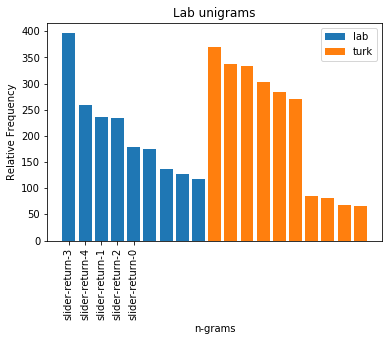

In [229]:
plt.bar(lab_unigrams['n-grams'].head(10), lab_unigrams['Relative Frequency'].head(10), label='lab')
plt.bar(turk_unigrams['n-grams'].head(10), turk_unigrams['Relative Frequency'].head(10), label='turk')

plt.xticks(('slider-return-0', 'slider-return-1', 'slider-return-2', 'slider-return-3', 'slider-return-4'))
plt.xlabel("n-grams")
plt.xticks(rotation=90)
plt.ylabel("Relative Frequency")
plt.title("Lab unigrams")
plt.legend(loc='best')

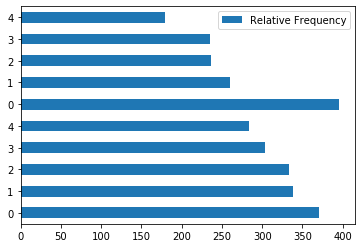

In [233]:
newdf = turk_unigrams[['n-grams', 'Relative Frequency']].head().append(lab_unigrams[['n-grams', 'Relative Frequency']].head())
newdf.plot.barh()

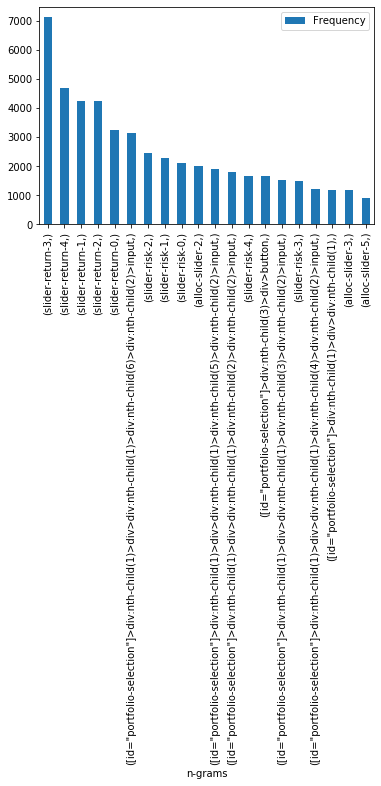

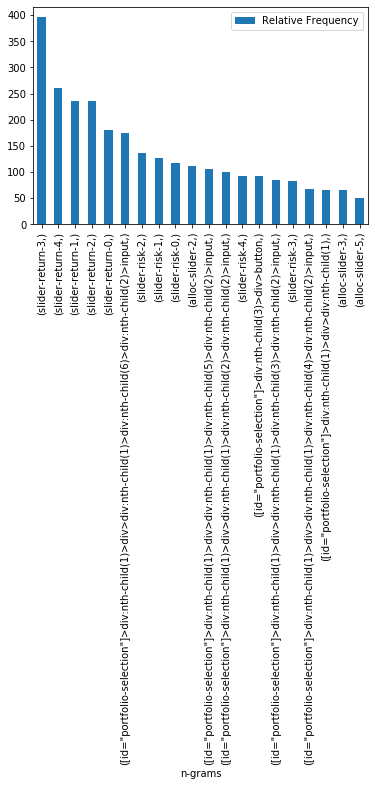

In [171]:
x.head(20).plot.bar(x='n-grams', y='Frequency')
x.head(20).plot.bar(x='n-grams', y='Relative Frequency')

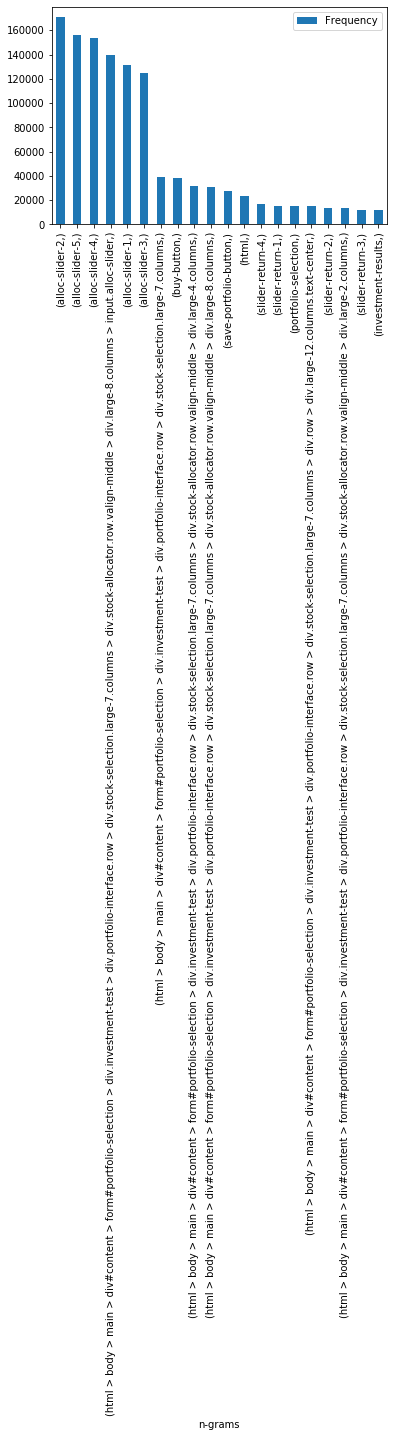

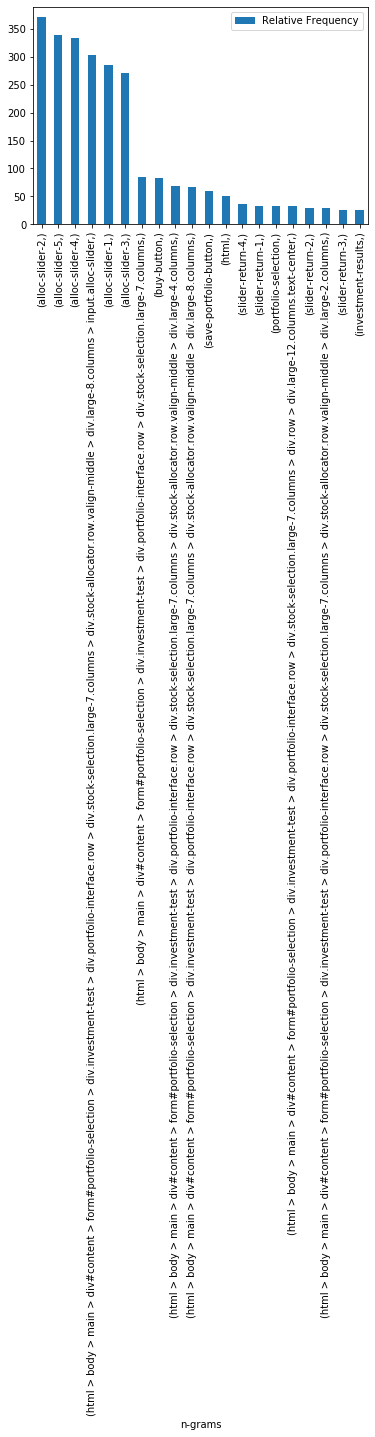

In [167]:
y.head(20).plot.bar(x='n-grams', y='Frequency')
y.head(20).plot.bar(x='n-grams', y='Relative Frequency')

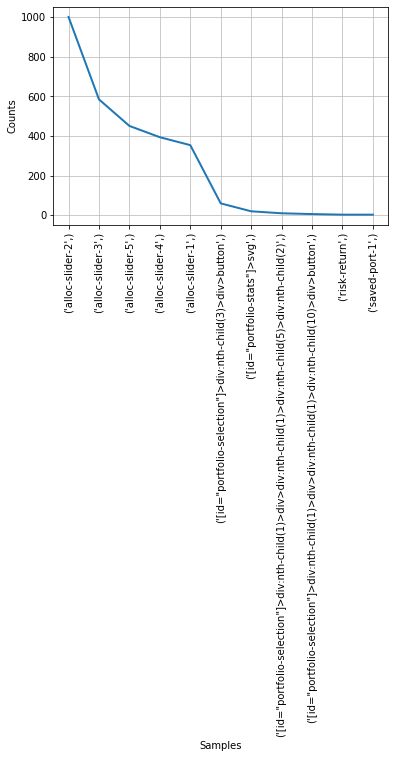

In [133]:
ngrams_generator = nltk.ngrams(targets, 1)               # creates ngram generator, can be used to find ngrams
ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency

ngrams_distribution.plot()

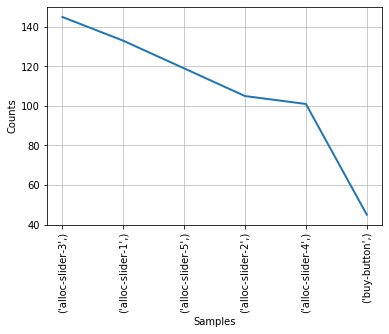

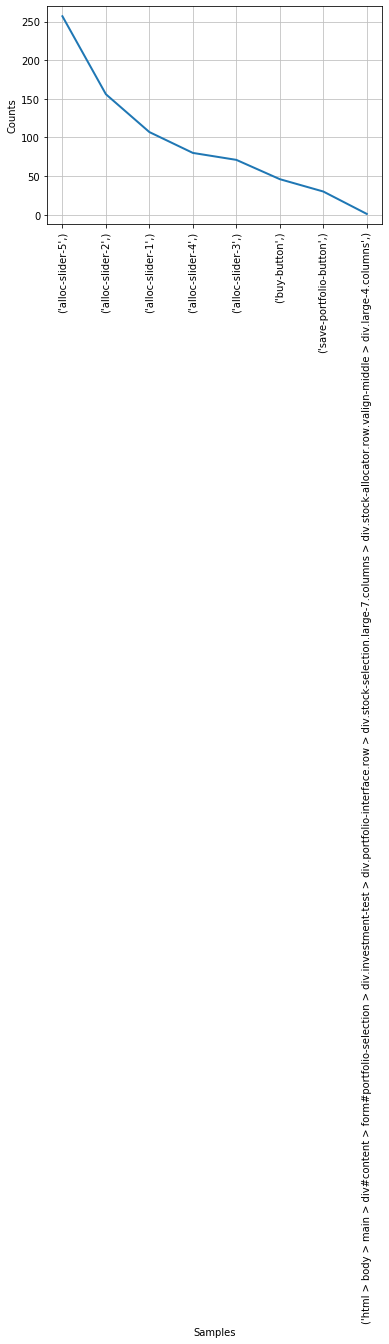

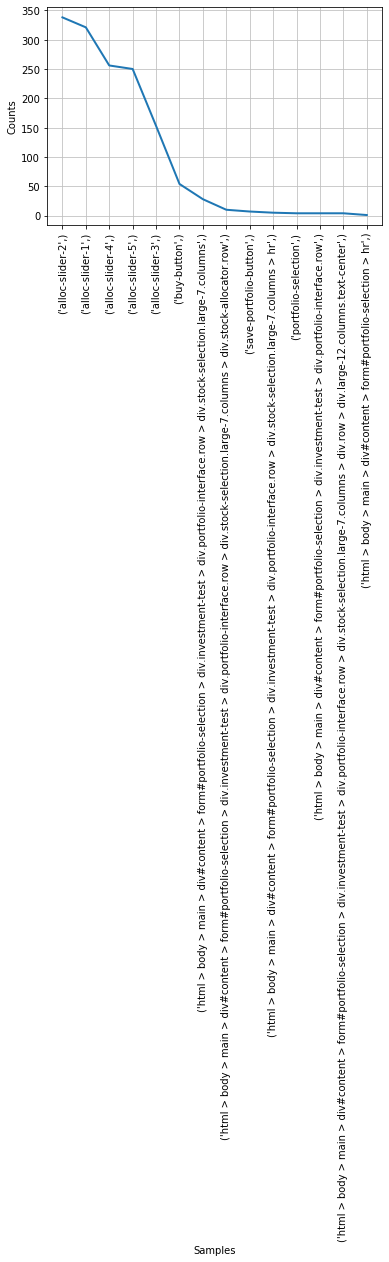

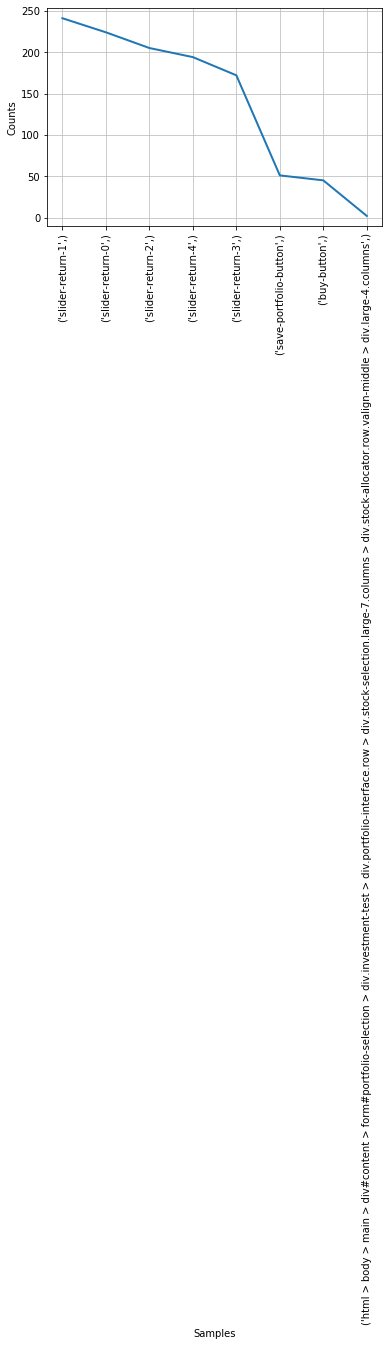

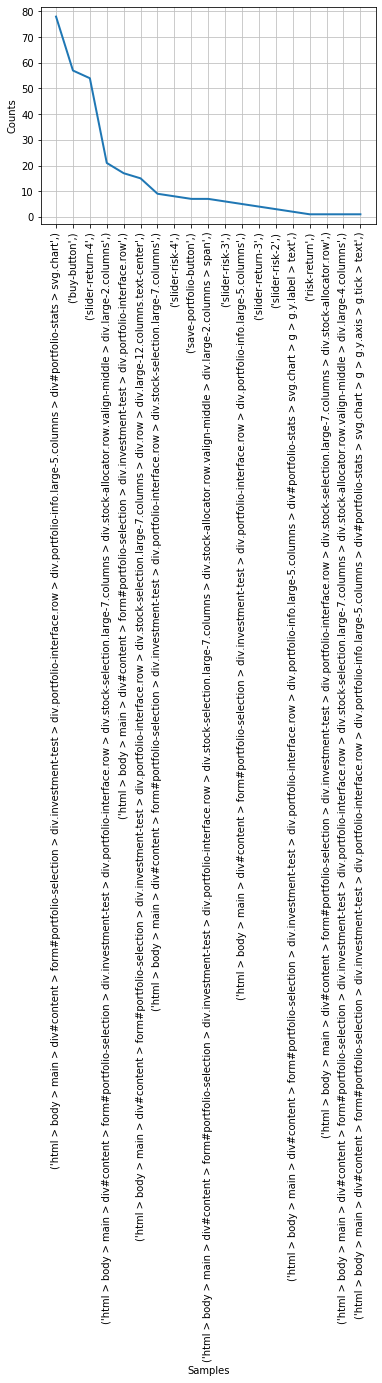

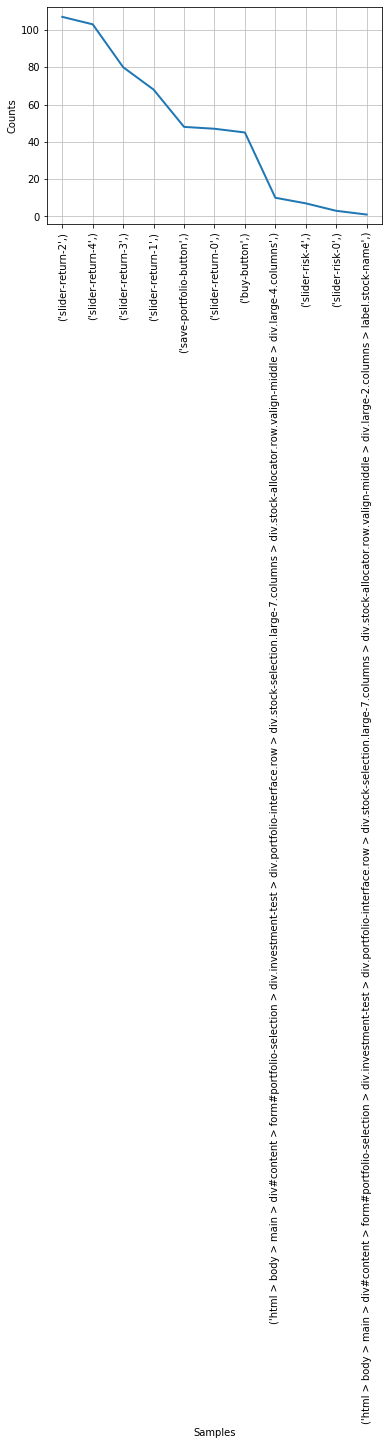

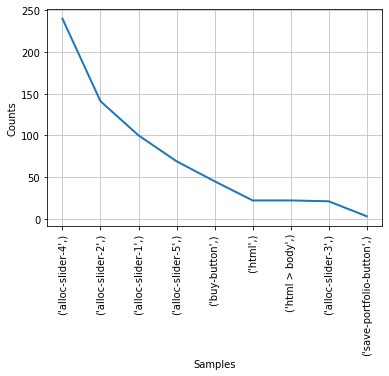

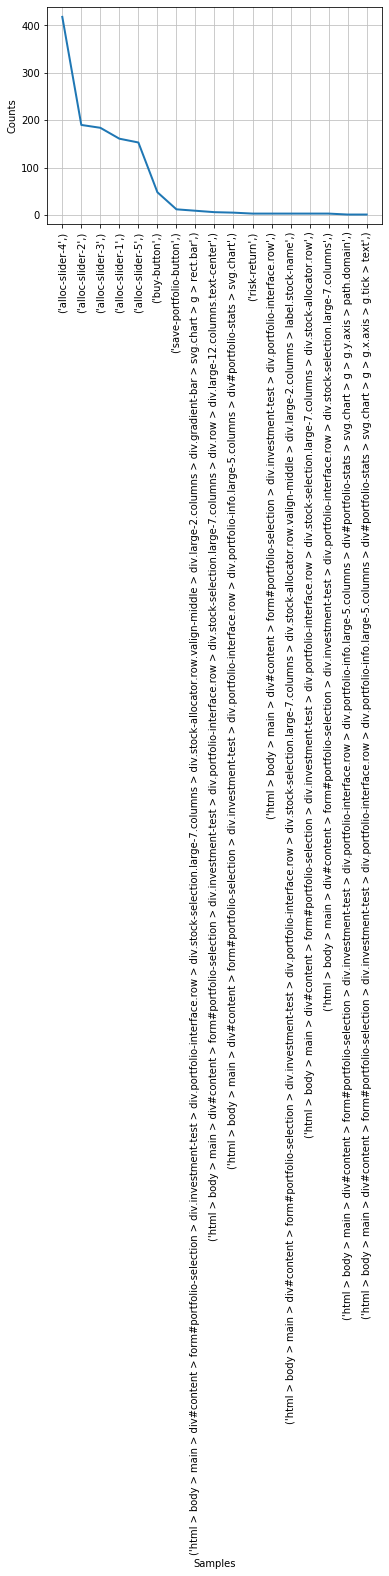

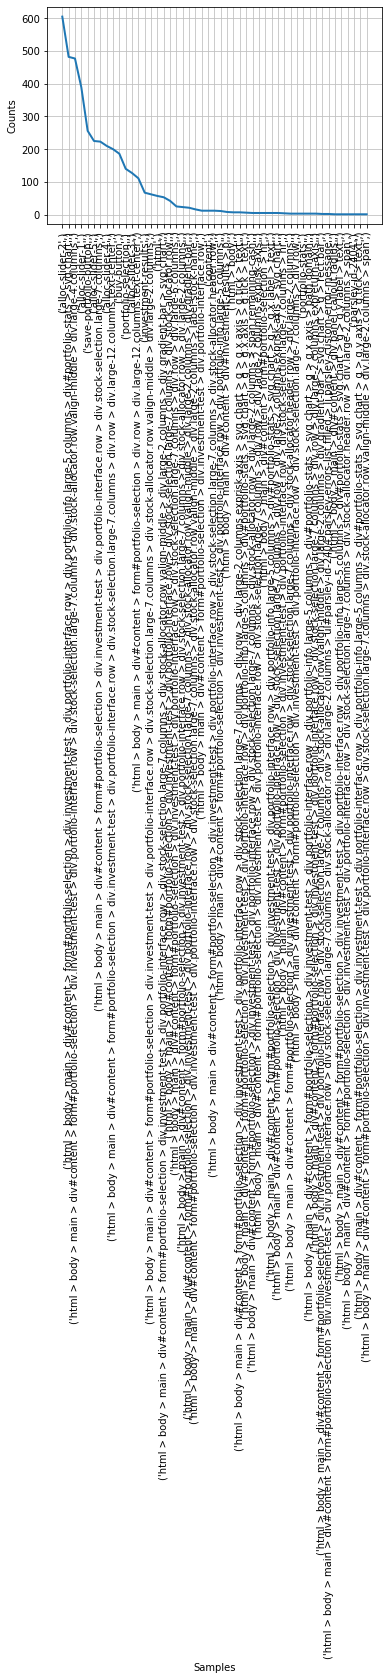

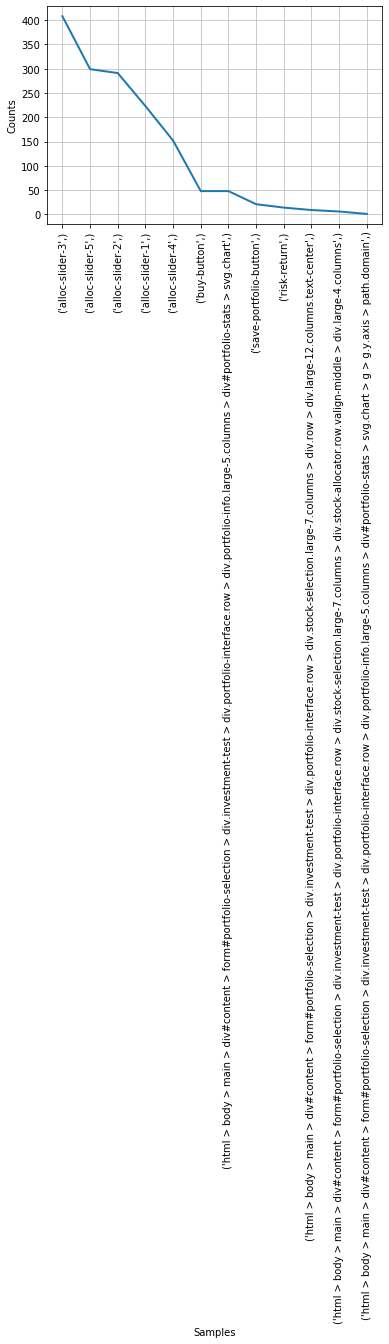

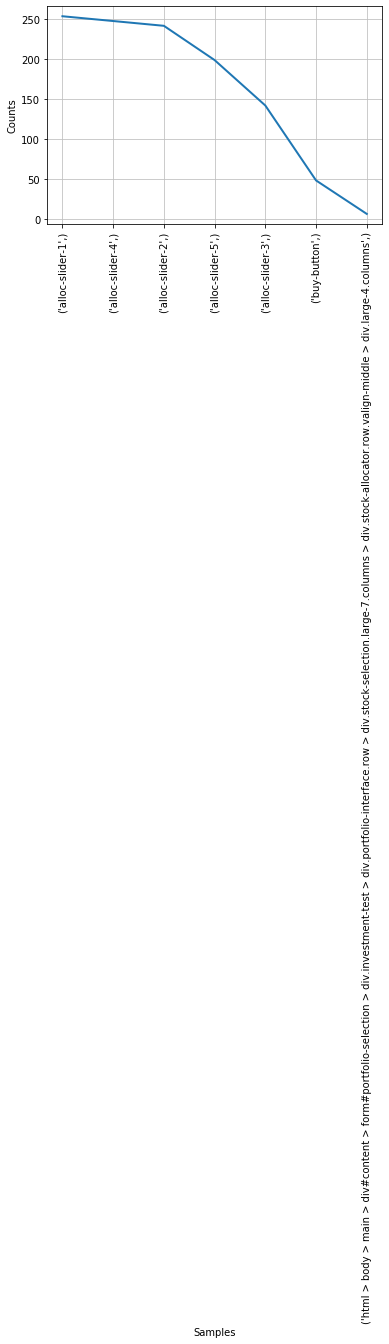

KeyboardInterrupt: 

In [138]:
visualise_ngrams(df_turk, 1)

In [116]:
# tear function apart and see whats going on and how it can apply to all users not just last one

dataframe = df_lab

IDs = dataframe['turkId'].unique()
all_ngrams = []

for ID in IDs:
    # Get targets of each user
    targets = dataframe[ dataframe['turkId'] == ID ] ['target'].to_numpy()

    ngrams_generator = nltk.ngrams(targets, 1)               # creates ngram generator, can be used to find ngrams
    ngrams_distribution = nltk.FreqDist(ngrams_generator)    # nltk distribution. in form ngrams:frequency
    common_ngrams = ngrams_distribution.most_common()       # converts to list

    # append this useres ngrams to all ngrams
    # extend rather than append to iterate over list and not add a list of items as a single item.
    all_ngrams.extend(common_ngrams)

# Convert list to dataframe
# Changed from all_ngrams to common_ngrams
df_ngrams = pd.DataFrame(all_ngrams, columns =['n-grams', 'Frequency'])

# Sum the frequencies of similar ngrams.
df_ngrams.groupby(['n-grams']).max()#.reset_index()#.sort_values(by='Frequency', ascending=False)
# 'Normalise' the frequencies to compare lab and turk.
# frequency of ngram divided by number of users
#df_ngrams['Relative Frequency'] = df_ngrams['Frequency'].divide(len(IDs))

#df_ngrams.groupby(['n-grams']).sum()

df_ngrams.groupby(['n-grams']).sum()

df_ngrams['Relative Frequency'] = df_ngrams['Frequency'].divide(len(IDs))

,Frequency
n-grams,
"([id=""alloc-slider-return-0""]>svg,)",1702
"([id=""alloc-slider-return-0""]>svg>g>circle,)",1314
"([id=""alloc-slider-return-0""]>svg>g>path,)",77
"([id=""alloc-slider-return-1""]>svg,)",2544
"([id=""alloc-slider-return-1""]>svg>g,)",2
...,...
"(risk-return,)",175
"(saved-port-0,)",75
"(saved-port-1,)",60


In [91]:
df_ngrams.groupby(['n-grams']).sum()

,Frequency
n-grams,
"([id=""alloc-slider-return-0""]>svg,)",1702
"([id=""alloc-slider-return-0""]>svg>g>circle,)",1314
"([id=""alloc-slider-return-0""]>svg>g>path,)",77
"([id=""alloc-slider-return-1""]>svg,)",2544
"([id=""alloc-slider-return-1""]>svg>g,)",2
...,...
"(risk-return,)",175
"(saved-port-0,)",75
"(saved-port-1,)",60


In [78]:

print(type(all_ngrams))
len(all_ngrams)


<class 'list'>


692

In [74]:
new = common_ngrams
new.extend(common_ngrams)
new

[(('alloc-slider-2',), 1001),
 (('alloc-slider-3',), 585),
 (('alloc-slider-5',), 451),
 (('alloc-slider-4',), 394),
 (('alloc-slider-1',), 354),
 (('[id="portfolio-selection"]>div:nth-child(3)>div>button',), 60),
 (('[id="portfolio-stats"]>svg',), 20),
 (('[id="portfolio-selection"]>div:nth-child(1)>div>div:nth-child(1)>div:nth-child(5)>div:nth-child(2)',),
  10),
 (('[id="portfolio-selection"]>div:nth-child(1)>div>div:nth-child(1)>div:nth-child(10)>div>button',),
  6),
 (('risk-return',), 3),
 (('saved-port-1',), 3),
 (('alloc-slider-2',), 1001),
 (('alloc-slider-3',), 585),
 (('alloc-slider-5',), 451),
 (('alloc-slider-4',), 394),
 (('alloc-slider-1',), 354),
 (('[id="portfolio-selection"]>div:nth-child(3)>div>button',), 60),
 (('[id="portfolio-stats"]>svg',), 20),
 (('[id="portfolio-selection"]>div:nth-child(1)>div>div:nth-child(1)>div:nth-child(5)>div:nth-child(2)',),
  10),
 (('[id="portfolio-selection"]>div:nth-child(1)>div>div:nth-child(1)>div:nth-child(10)>div>button',),
  6),

In [11]:
#